In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
#import serial

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
class FLEMG_Data_Collector:
	def __init__(self, flex_size = 6, emg_size = 8):
		self.data = []
		self.count = 0

		self.flex_data_size = flex_size
		self.flex_port = None
		self.fleg_port_flag = False

		self.emg_data_size = emg_size
		self.emg_port = None
		self.emg_port_flag = False

	def open_port(self, flex_port_name, emg_port_name):
    # Instantiate and Open Serial Ports
		self.flex_port = serial.Serial(flex_port_name, 115200, timeout=2)
		self.emg_port = serial.Serial(emg_port_name, 19200, timeout=2)

    # Set member values related to the ports
		if self.flex_port.is_open:
			self_flex_port_flag = True
			print('FLEX serial port open')
		else:
			print('FLEX serial not open')

		if self.emg_port.is_open:
			self_emg_port_flag = True
			print('EMG serial port open')
		else:
			print('EMG serial not open')

	def close_port(self):
		if self.flex_port.is_open:
			self.flex_port.close()
			self.flex_port_flag = False
			print('EMG serial port close')

		if self.emg_port.is_open:
			self.emg_port.close()
			self.emg_port_flag = False
			print('FLEX serial port close')

	def receive_data(self):
		validation = False
		flex_tmp = []
		emg_tmp = []

		# Receive a data through port
		## FLEX data
		if self.flex_port_flag and self.flex_port.inWaiting():
			input_flex = self.flex_port.read(self.flex_data_size)
			decoded_flex = input_flex.decode('ascii')
		## EMG data
		if self.emg_port_flag and self.emg_port.inWaiting():
			input_emg=self.emg_port.read(self.emg_data_size)
			decoded_emg=input_emg.decode('ascii')

		for i in range(len(decoded_flex)):
			if decoded_flex[i]=='n'and stack==4 :
				stack=0
				validation=True
			elif decoded_flex[i]=='n' and stack!=4:
				validation=False
				stack=0
				print('FLEX data receiving error')
			elif decoded_flex[i]==',':
				stack += 1
			else:
				flex_tmp.append(decoded_flex[i])

		##check validation of input emg data and get a line of sensor data
		for i in range(len(decoded_emg)):
			if decoded_emg[i]=='[':
				start_index=i;
				stack = 0
			elif decoded_emg[i]==']' and stack==7 :
				end_index=i;
				stack = 0
				validation=True
			elif decoded_emg[i]==']' and stack!=7 :
				validation=False
				stack = 0
				print('EMG data receiving error')
			elif decoded_emg[i]==',':
				stack += 1
			else:
				emg_tmp.append(decoded_emg[i])

		# Increment self.count
		if validation is True:
			self.data.append([count] + flex_tmp + emg_tmp)
			self.count = self.count + 1

	def print_data(self, count = None):
		if count is not None:
			print(self.data[-count:])
		else:
			print(self.data)

	def save_data_set(self, location='default.csv', delimiter=',', format ='%d'):
		np.savetxt(location, self.data, delimiter=delimiter, fmt=format)
		print("Save FLEMG dataset to " + str(location))

	def load_data_set(self, location='default', delimiter=','):
		self.data = np.loadtxt(location, delimiter = delimiter)
		self.data_count = len(self.data)
		print("Load FLEMG dataset from " + str(location))

In [87]:
class Preprocessor:
	def __init__(self, raw = [], data_dim = 8, label_dim = 6, index_dim = 1, seq_length = 3):
		self.raw = raw
        
		self.data = []
		self.label = []
		self.count = 0
		self.index = []
        
		self.data_dim = data_dim
		self.label_dim = label_dim
		self.index_dim = index_dim
		self.seq_length = seq_length

	def load(self, location='default', delimiter = ','):
		self.raw = np.loadtxt(location, delimiter = delimiter)
        
	def scale(self, emg_max = 1024, flex_max = 128, chunk = 30):
		w_e=emg_max/chunk
		w_f=flex_max/chunk
		e_f=emg_max/flex_max

		denominator = [1/w_e, e_f,e_f,e_f,e_f,e_f,e_f,e_f,e_f,chunk,chunk,chunk,chunk,chunk,chunk]
		self.raw = np.round(self.raw/denominator)/(w_e)
        
	def preprocess(self):
		if (self.seq_length <= len(self.data)):
			print("Error : seqence length " + self.seq_length + " is shorter than data count " + len(self.data))
			return
            
		dataX = []
		dataY = []
		dataT = []
		for i in range(len(self.raw) - self.seq_length + 1):
			_x = self.raw[i:i+self.seq_length, self.index_dim:]
			_y = self.raw[i+self.seq_length-1, self.index_dim+self.data_dim:]  # Next close price
			_t = self.raw[i:i+self.seq_length, :self.index_dim]
			dataX.append(_x)
			dataY.append(_y)
			dataT.append(_t)
		self.data = np.array(dataX)
		self.label = np.array(dataY)
		self.count = len(self.data)
		self.index = np.array(dataT)

In [71]:
class LSTM_Network:
	def __init__(self, data_processor = Preprocessor(), hidden_dim = 30, learning_rate = 0.01, LSTM_stack = 2):
		tf.set_random_seed(777)  # reproducibility
		self.data_processor = data_processor
		self.seq_length = data_processor.seq_length
		self.data_dim = data_processor.data_dim
		self.output_dim = data_processor.label_dim
		self.hidden_dim = hidden_dim
		self.learning_rate = learning_rate
		self.LSTM_stack = LSTM_stack
        
		self.graph = tf.Graph()
		self.sess = tf.Session()
        
		self.flag_kernel_opened = False
		self.flag_placeholder = False

	# build a LSTM network
	def build_cell(self):
		cell = tf.contrib.rnn.BasicLSTMCell(num_units = self.hidden_dim, state_is_tuple=True)
		return cell

	def construct_placeholders(self):
		if (self.flag_kernel_opened) :
			print("reset kernel")
			tf.reset_default_graph()
		# Input Place holders
		self.X = tf.placeholder(tf.float32, [None, self.seq_length, self.data_dim+self.output_dim])
		self.Y = tf.placeholder(tf.float32, [None, self.output_dim])

		# Build a LSTM network
		multi_cells = tf.contrib.rnn.MultiRNNCell([self.build_cell() for _ in range(self.LSTM_stack)], state_is_tuple=True)
		outputs, _states=tf.nn.dynamic_rnn(multi_cells, self.X, dtype=tf.float32)
		self.Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], self.output_dim)

		# Cost & Loss & Optimizer
		loss = tf.reduce_sum(tf.square(self.Y_pred - self.Y))  # sum of the squares
		optimizer = tf.train.AdamOptimizer(self.learning_rate)
		train = optimizer.minimize(loss)

		# RMSE
		self.targets = tf.placeholder(tf.float32, [None, self.output_dim])
		self.predictions = tf.placeholder(tf.float32, [None, self.output_dim])
		self.rmse = tf.sqrt(tf.reduce_mean(tf.square(self.targets - self.predictions)))
        
		self.flag_kernel_opened = True
		self.flag_placeholder = True

	def restore_network(self, location='checkpoints'):
		if (not self.flag_placeholder) :
			self.construct_placeholders()
		self.saver = tf.train.Saver()
		self.saver.restore(self.sess, tf.train.latest_checkpoint(location))

	def infer(self, data_processor = None, default_ = 0.39):
		if data_processor is None:
			data_processor = self.data_processor
		prediction = []

		# Test step
		testX = data_processor.data
		for idx in range(len(testX)) :
			if idx == 0:
				for j in range(data_processor.label_dim):
					for l in range(data_processor.seq_length):
						testX[idx, l, j + (data_processor.index_dim + data_processor.data_dim - 1)] = default_
				test_predict = self.sess.run(self.Y_pred, feed_dict={self.X: [testX[idx]]})
			elif idx < data_processor.seq_length:
				for j in range(data_processor.label_dim):
					for l in range(data_processor.seq_length):
						if data_processor.seq_length == l:
							testX[idx, l, j + (data_processor.index_dim + data_processor.data_dim - 1)] = test_predict[0][j]
						elif idx < l:
							testX[idx, l, j + (data_processor.index_dim + data_processor.data_dim - 1)] = testX[idx-(data_processor.seq_length-l),data_processor.seq_length-1,j+data_processor.data_dim]
						else:
							testX[idx, l, j + (data_processor.index_dim + data_processor.data_dim - 1)] = default_
				test_predict = self.sess.run(self.Y_pred, feed_dict={self.X: [testX[idx]]})
			else: 
				for j in range(data_processor.label_dim):
					for l in range(data_processor.seq_length):
						if data_processor.seq_length == l:
							testX[idx, l, j + (data_processor.index_dim + data_processor.data_dim - 1)] = test_predict[0][j]
						elif idx < l:
							testX[idx, l, j + (data_processor.index_dim + data_processor.data_dim - 1)] = testX[idx-(data_processor.seq_length-l),data_processor.seq_length-1,j+data_processor.data_dim]
				test_predict = self.sess.run(self.Y_pred, feed_dict= {self.X: [testX[idx]]})
    
			prediction.append(test_predict[0])
        
        # Calculate RMSE
		rmse_val = self.sess.run(self.rmse, feed_dict={self.targets: data_processor.label, self.predictions: prediction})
		print("RMSE: {}".format(rmse_val))
		return prediction

	def close(self):
		tf.reset_default_graph()
		self.sess.close()

# Example

In [90]:
data_collector = FLEMG_Data_Collector()
data_collector.load_data_set('./data/full.csv')
#data_collector.save_data_set(format='%d')
print( len(data_collector.data) )

trainer = Preprocessor(data_collector.data, seq_length = 5)
trainer.scale()
trainer.preprocess()

print( trainer.data.shape )
print( trainer.label.shape )
print( trainer.index.shape )

Load FLEMG dataset from ./data/full.csv
3198
(3194, 5, 14)
(3194, 6)
(3194, 5, 1)


In [91]:
tf.reset_default_graph()

Network = LSTM_Network(trainer)
Network.restore_network()
print( trainer.data.shape )
print( trainer.label.shape )
print( trainer.index.shape )
prediction = Network.infer()

Network.close()

INFO:tensorflow:Restoring parameters from checkpoints/rnn.ckpt


(3194, 5, 14)
(3194, 6)
(3194, 5, 1)


RMSE: 0.15342622995376587


In [81]:
infer_target = Preprocessor(data_collector.data[ -5 : ], seq_length = 5)

Network = LSTM_Network(infer_target)
Network.restore_network()
infer_target.scale()
infer_target.preprocess()
print( infer_target.label.shape )
prediction = Network.infer(infer_target)
Network.close()

INFO:tensorflow:Restoring parameters from checkpoints/rnn.ckpt


(1, 6)
RMSE: 13.567753791809082


In [89]:
infer_target = Preprocessor(data_collector.data[ -int((len(data_collector.data) * 0.3)) : ], seq_length = 5)

Network = LSTM_Network(infer_target)
Network.restore_network()
infer_target.scale()
infer_target.preprocess()
print( infer_target.label.shape )
print( infer_target.label[450])
prediction = Network.infer(infer_target)
Network.close()

INFO:tensorflow:Restoring parameters from checkpoints/rnn.ckpt


(955, 6)
[0.38085938 0.41015625 0.41015625 0.38085938 0.41015625 0.41015625]


RMSE: 0.1484842598438263


NameError: name 'train' is not defined

<Figure size 432x288 with 0 Axes>

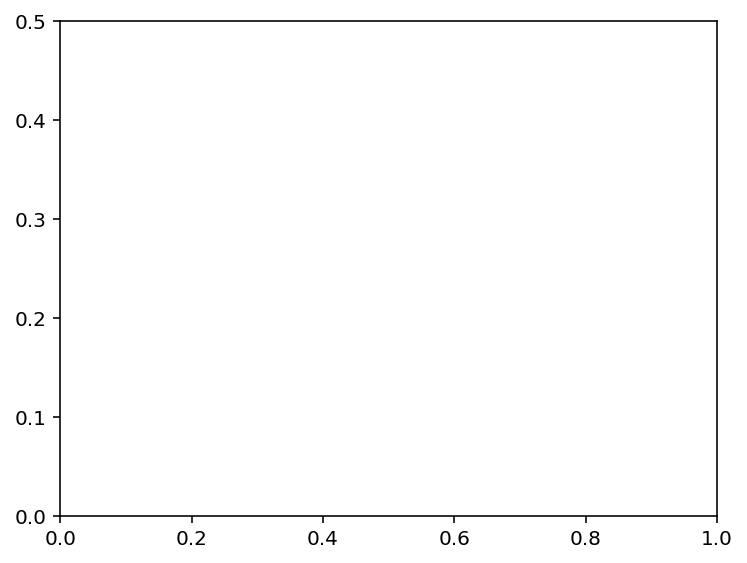

In [83]:
prediction = np.asarray(prediction)

plt.figure(2)
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.ylim([0,0.5])
print(train.index[:,:,0].shape)
print(prediction[:,0].shape)
print(trainer.label[:,0].shape)

plt.plot(trainer.index[:,:,0],prediction[:,0],'r',trainer.index[:,:,0],trainer.label[:,0],'b')
plt.subplot(2,3,2)
plt.ylim([0,0.5])
plt.plot(testT[:,:,0],prediction[:,1],'r',testT[:,:,0],testY[:,1],'b')
plt.subplot(2,3,3)
plt.ylim([0,0.5])
plt.plot(testT[:,:,0],prediction[:,2],'r',testT[:,:,0],testY[:,2],'b')
plt.subplot(2,3,4)
plt.ylim([0,0.5])
plt.plot(testT[:,:,0],prediction[:,3],'r',testT[:,:,0],testY[:,3],'b')
plt.subplot(2,3,5)
plt.ylim([0,0.5])
plt.plot(testT[:,:,0],prediction[:,4],'r',testT[:,:,0],testY[:,4],'b')
plt.subplot(2,3,6)
plt.ylim([0,0.5])
plt.plot(testT[:,:,0],prediction[:,5],'r',testT[:,:,0],testY[:,5],'b')